In [20]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import shuffle
import pandas as pd
from sklearn.decomposition import PCA
from scipy import stats
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('http_requests.csv', sep=',', error_bad_lines=False, index_col=False, dtype='unicode')
df = shuffle(df)
df['payload'] = df['payload'].fillna(0)
df['payload'] = df['payload'].apply(lambda x: str(x))
df.drop(columns=['index', 'method', 'url', 'protocol', 'userAgent', 'pragma', 'cacheControl', 'accept', 'acceptEncoding', 'acceptCharset', 'acceptLanguage', 'host', 'connection', 'contentLength', 'contentType', 'cookie'], inplace=True)

In [3]:
print(df.head())

                             payload label
96302   direccion=Pereiro%2C+1+9%3FB  anom
102208                 modo=registro  anom
166681                             0  norm
169312                    precio=100  norm
39243       apellidos=Giorgis+Zabala  anom


In [4]:
# Function to generate a 255 dim feature vector from 'payload'
# Return a list of length 255 with features of payloads mapped to it
# Each list index represents an ASCII character and value represents count
# q = [4, 5, 2, 6, 12,  ....]


def vectorize_payload(payload):
    vec_255 = [0]*255
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 1))
    vectorized = vectorizer.fit_transform([payload])
    mapped = list(zip(vectorizer.get_feature_names(), vectorized.sum(0).getA1()))
    for x in mapped:
        vec_255[ord(x[0])] = x[1]
    return vec_255


In [5]:
# conversion to 256 dimensional vector
vectors = np.array(df['payload'].apply(lambda x: vectorize_payload(x)))
vectors


array([list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 3, 1, 0, 0, 3, 0, 0, 0, 0, 1, 2, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
       list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

In [6]:
# Function to generate frequency for 255 dim feature vectors
# Return a list of length 255 with feature frequencies
# Each list index represents an ASCII character and value represents its frequency
# q = [0.23, 0, 0, 0.03, 0.42,  ....] = 1


def calc_frequency(payloads_vectors):
    features_total = 0
    for feature in payloads_vectors:
        features_total += feature
    features_total *= 1.0
    payloads_vectors = [(x/features_total) for x in payloads_vectors]
    return np.array(payloads_vectors, dtype=np.float16)


results = [calc_frequency(x) for x in vectors]
features_frequency = np.vstack(results)
del results


In [9]:
# Function to generate mean vector for n payloads
# Assuming data set has traffic of n packets
# Return a list of length 255 with mean for every 255 features from payload vectors
# x' = [2.3, 3.1, 2.23, 7.5, 12.2,  ....]


def calc_mean(frequency_vectors):
    # TOTAL_PACKETS = len(vectors)
    # compiled = [0.0]*255
    # for x in frequency_vectors:
    #     compiled = list(map(sum, zip(compiled, x)))
    # return np.array([x/(TOTAL_PACKETS*1.0) for x in compiled], dtype=np.float16)
    return np.mean(frequency_vectors, axis=0)


features_mean = calc_mean(features_frequency)


In [53]:
# Function to generate sample covariance matrix n-1
# Assuming data set has traffic of n packets
# Return a covariance matrix for given frequency vectors


def calc_cov_mat():
    TOTAL_OBSERVATIONS = len(vectors)
    mean_shift = np.transpose(np.subtract(features_frequency, features_mean))    
    return np.cov(mean_shift), mean_shift


cov_mat, mean_shift = calc_cov_mat()


In [11]:
eig_val, eig_vec = np.linalg.eigh(cov_mat)

In [55]:
idx = np.argsort(eig_val)[::-1]
evecs = eig_vec[:,idx]
evals = eig_val[idx]
evecs = evecs[:, :2]

In [ ]:
eig_pairs = [(np.abs(eig_val[x]), eig_vec[:,x]) for x in range(len(eig_val))]
for i in eig_pairs:
    print(i[0])


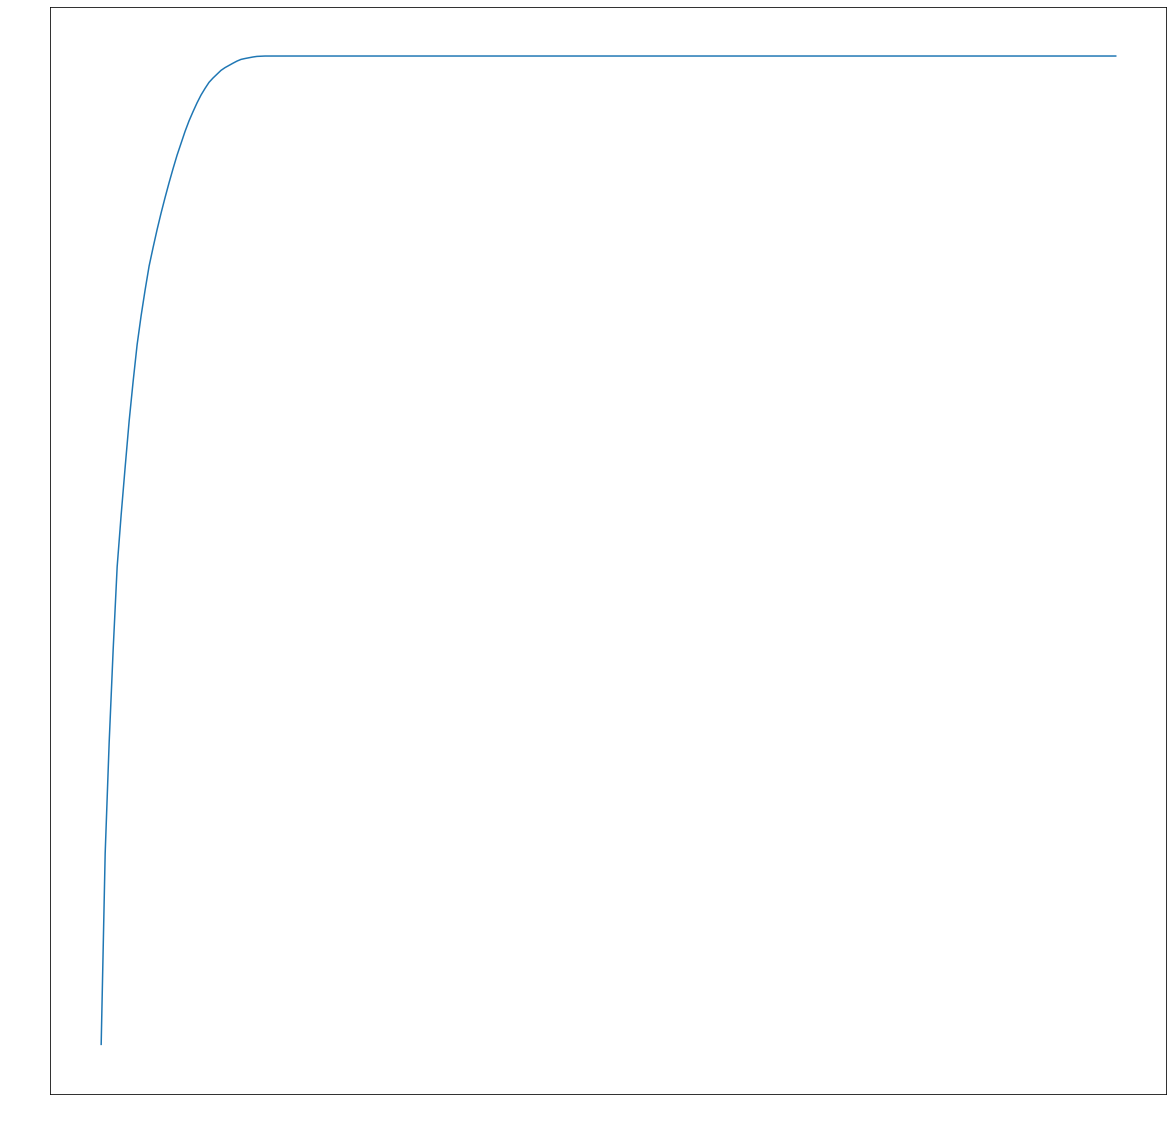

In [35]:
pca = PCA()
pca.fit_transform(features_frequency)
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot()
ax.plot(np.cumsum(pca.explained_variance_ratio_))

ax.set_xlabel('number of components')
ax.set_ylabel('cumulative explained variance')

ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

plt.show()


In [ ]:
np.dot(evecs.T, mean_shift.T)

[(0.10472509332708586,
  array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00, -1.30562555e-02,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00, -2.33028284e-04, -1.65297111e-02,
          0.00000000e+00, -1.05943709e-03, -1.70362855e-03, -1.02887081e-05,
          9.74342621e-01, -2.43979714e-02, -1.7882919

In [58]:
evecs

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.

In [62]:
data_resc = np.dot(evecs.T, mean_shift).T

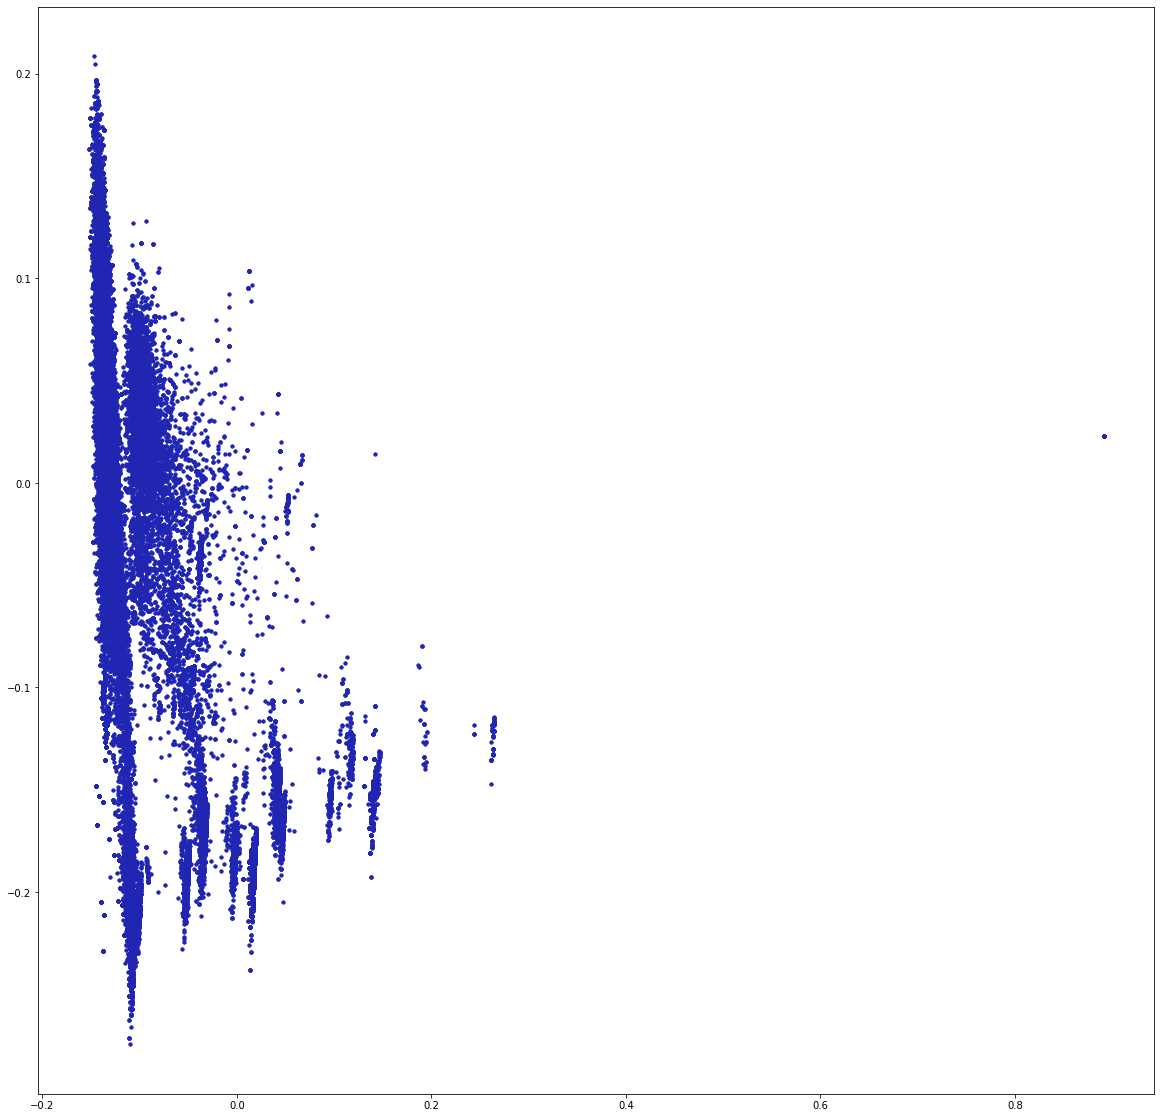

In [64]:
clr1 = '#2026B2'
fig2 = plt.figure(figsize=(20, 20))
ax1 = fig2.add_subplot(111)
ax1.plot(data_resc[:, 0], data_resc[:, 1], '.', mfc=clr1, mec=clr1)
plt.show()

In [68]:
data_resc[:, 0]

array([-0.13029337, -0.14456102,  0.89118541, ..., -0.14302575,
       -0.10697168, -0.13645859])